In [1]:
from jacobi.complex_step import jacobi as cjac
from jacobi.real_step import jacobi as rjac
import numpy as np
from matplotlib import pyplot as plt

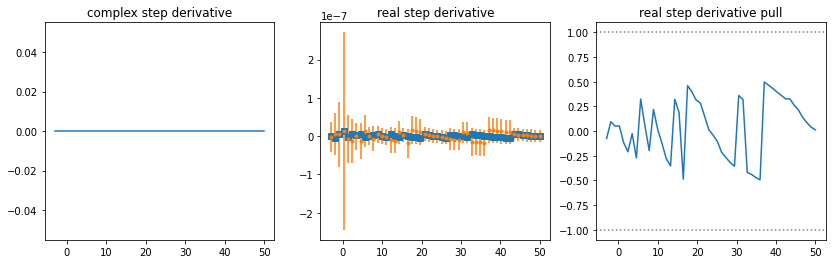

In [2]:
x = np.linspace(-3, 50)
f = np.exp
y = f(x)
dy0 = y
dy1 = cjac(f, x)
dy2 = rjac(f, x)
dy3, dy3e = rjac(f, x, True)
fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True)
ax[0].set_title("complex step derivative")
ax[0].plot(x, dy1/ dy0 - 1, zorder=1)
ax[1].set_title("real step derivative")
ax[1].plot(x, dy2/ dy0 - 1, "s", zorder=2)
ax[1].errorbar(x, dy3/ dy0 - 1, dy3e / dy0, fmt=".", zorder=2)
ax[2].set_title("real step derivative pull")
ax[2].plot(x, (dy3 - dy0) / dy3e, 1)
for y in (-1,1):
    ax[2].axhline(y, ls=":", color="0.5")

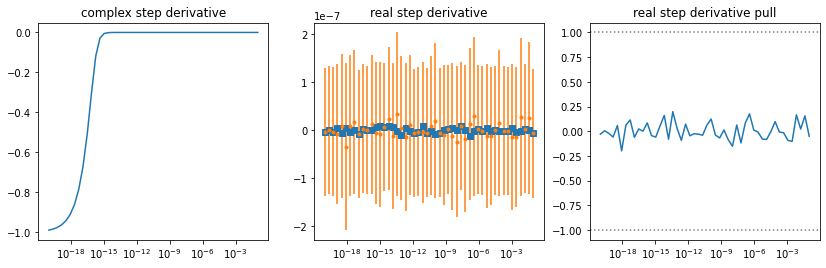

In [3]:
x = np.geomspace(1e-20, 0.1)
f = np.sqrt
y = f(x)
dy0 = 0.5 * x ** -0.5
dy1 = cjac(f, x)
dy2 = rjac(f, x)
dy3, dy3e = rjac(f, x, True)
fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True)
ax[0].set_title("complex step derivative")
ax[0].plot(x, dy1/ dy0 - 1, zorder=1)
ax[1].set_title("real step derivative")
ax[1].plot(x, dy2/ dy0 - 1, "s", zorder=2)
ax[1].errorbar(x, dy3/ dy0 - 1, dy3e / dy0, fmt=".", zorder=2)
ax[2].set_title("real step derivative pull")
ax[2].plot(x, (dy3 - dy0) / dy3e, 1)
for y in (-1,1):
    ax[2].axhline(y, ls=":", color="0.5")
plt.semilogx();

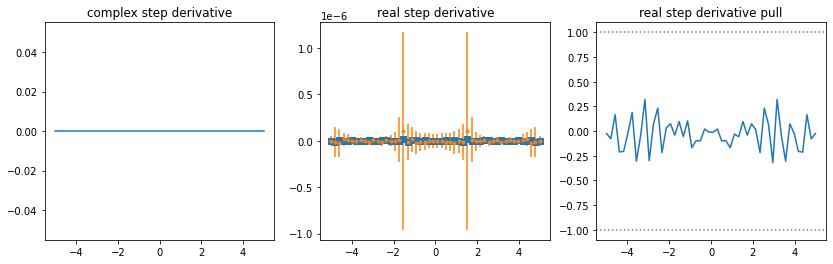

In [4]:
f = np.sin
x = np.linspace(-5, 5)
y = f(x)
dy0 = np.cos(x)
dy1 = cjac(f, x)
dy2 = rjac(f, x)
dy3, dy3e = rjac(f, x, True)
fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True)
ax[0].set_title("complex step derivative")
ax[0].plot(x, dy1/ dy0 - 1, zorder=1)
ax[1].set_title("real step derivative")
ax[1].plot(x, dy2/ dy0 - 1, "s", zorder=2)
ax[1].errorbar(x, dy3/ dy0 - 1, dy3e / dy0, fmt=".", zorder=2)
ax[2].set_title("real step derivative pull")
ax[2].plot(x, (dy3 - dy0) / dy3e, 1)
for y in (-1,1):
    ax[2].axhline(y, ls=":", color="0.5");

[-3.47270661 -5.00583298 -3.99398198 -4.21022983 -4.21990788 -4.13234596
 -4.17163347 -4.17988438 -4.17074098 -4.16902953 -4.17137024 -4.17058869
 -4.17083078 -4.17094515 -4.17088224 -4.17092735 -4.17090167 -4.17091423
 -4.1709088  -4.17090825 -4.17090814 -4.17090791 -4.17090803 -4.17090821
 -4.17090817 -4.17090815 -4.17090814 -4.17090815 -4.17090814 -4.17090814
 -4.17090814 -4.17090814 -4.17090814 -4.17090814 -4.17090813 -4.17090807
 -4.17090783 -4.17090677 -4.17090215 -4.17088204 -4.17079449 -4.17041326
 -4.16875353 -4.16153112 -4.13016988 -3.99526121 -3.43826864 -1.52767327
  0.9013094   0.0723063 ]
[0.09752902 0.08922778 0.08552039 0.09270082 0.09165489 0.09143223
 0.09106985 0.09109439 0.09110765 0.09108074 0.09110269 0.0911013
 0.09110145 0.09109891 0.09109763 0.09109839 0.09109825 0.09109823
 0.09109818 0.09109819 0.09109817 0.09109817 0.09109817 0.09109817
 0.09109817 0.09109817 0.09109817 0.09109817 0.09109817 0.09109817
 0.09109817 0.09109817 0.09109817 0.09109817 0.09109817 

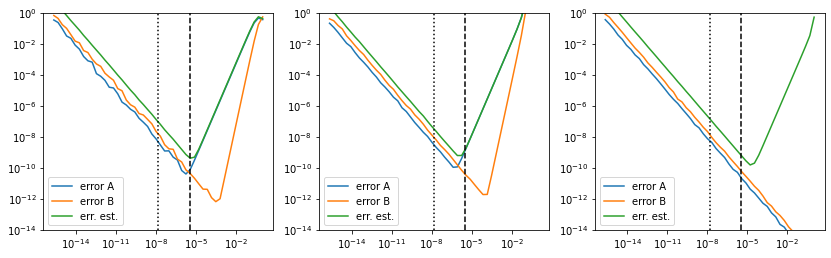

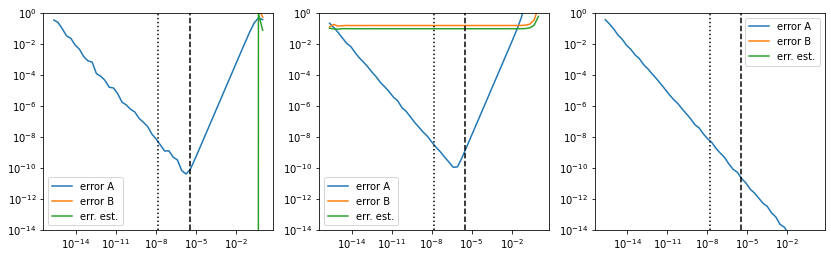

In [7]:
from jacobi.real_step import central, forward
eps = np.finfo(float).eps

h = np.geomspace(eps, 1)

for deriv in (central, forward):

    fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True)
    for axi, f, df, x in (
        (ax[0], np.sin, np.cos, np.linspace(-10, 10)),
        (ax[1], np.exp, np.exp, np.linspace(-5, 50)),
        (ax[2], np.sqrt, lambda x: 0.5 * x ** -0.5, np.geomspace(1e-10, 1)),
    ):
        dy0 = df(x)
        s1 = np.vectorize(lambda h: np.nanstd(deriv(f, x, np.abs(h * x)) / dy0))(h)
        s2 = np.vectorize(lambda h: np.nanstd(deriv(f, x, np.abs(h * x), True)[0] / dy0))(h)
        se = np.vectorize(lambda h: np.nanmean(deriv(f, x, np.abs(h * x), True)[1] / np.abs(dy0)))(h)
        
        if deriv is forward:
            print(se)
        plt.sca(axi)
        plt.plot(h, s1, label="error A")
        plt.plot(h, s2, label="error B")
        plt.plot(h, se, label="err. est.")
        plt.legend()

        plt.axvline(eps ** 0.5, ls=":", color="k")
        plt.axvline(eps ** 0.35, ls="--", color="k")
        plt.ylim(1e-14, 1)
        plt.loglog();